In [ ]:
import os
import os


import random
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import meerkat as mk
from domino import DominoSlicer
from classifer_v5 import *
from bootstrap_utilis import *
from sklearn.metrics import accuracy_score



In [ ]:
# V12 & V13
# This is a sample run for "Finding vs. Postition". 
# The noise strength is 0.3.
# Position 1 (frontal) and Position 2 (lateral) 
# We would like to have Classifier that underperforms when the sample is frontal 


### Data Preparation

In [2]:
label_1 = 'Finding'
label_2 = 'Position'
attribute = True
print("=================== Bootstrap Experiment ==========")
print(f"This the experiment for {label_1} and {label_2} labels")
test_df = pd.read_parquet("/vol/bitbucket/yl28218/thesis/mimic_cxr_exp/data/test_df_position.parquet")
print("Loading test and train DataFrames...")
train_df = pd.read_parquet("/vol/bitbucket/yl28218/thesis/mimic_cxr_exp/data/train_df_position.parquet")
print("Create the embeddings for the test DataFrame...")
test_df["combined_embedding"] = get_combined_embedding(test_df, 'image_embedding', 'report_embedding', n_components=512)
test_df["combined_emebdding_v2"] = get_combined_embedding(test_df, 'image_embedding', 'report_embedding', 'metadata_embedding', 512)
test_df["combined_embedding_v3"] = get_combined_embedding(test_df, 'report_embedding', 'metadata_embedding', n_components=512)
test_df["combined_embedding_v4"] = get_combined_embedding(test_df, 'image_embedding', 'metadata_embedding')
root_folder = "/vol/bitbucket/yl28218/thesis/physionet.org/files/mimic-cxr-jpg/2.1.0/files"
selected_columns = [label_2, 'predicted', 'true', 'id', 'path', 'report_text', 'image_embedding', 'report_embedding', 'metadata_embedding', "Rows", "Columns", "metadata_description", "combined_embedding", "combined_emebdding_v2", "combined_embedding_v3", "combined_embedding_v4"]
checkpointpath = None
token_results = {"image_only": [], "image_text": [], "image_text_meta": [], "text": [], "meta": [], "report_metadata": [], "image_metadata": []}


    
seed =42
k = 10
max_features = 1000

threshold = 0.1

=================== Bootstrap Experiment ==========
This the experiment for Finding and Position labels
Loading test and train DataFrames...
Create the embeddings for the test DataFrame...


In [270]:
# if portable in metadata, then it is portable (1) or not (0)
print("Creating the 'is_portable' column in the train DataFrame...")
train_df["is_portable"] = train_df['metadata_description'].apply(lambda x: 1 if 'portable' in x.lower() else 0)
# if portable in metadata, then it is portable (1) or not (0)
print("Creating the 'is_portable' column in the test DataFrame...")
test_df["is_portable"] = test_df['metadata_description'].apply(lambda x: 1 if 'portable' in x.lower() else 0)
 

Creating the 'is_portable' column in the train DataFrame...
Creating the 'is_portable' column in the test DataFrame...


In [18]:
test_df.groupby([label_2, label_1]).size().reset_index(name='count')


,is_portable,Finding,count
0,0,0,356
1,0,1,1737
2,1,0,518
3,1,1,5786


### Classifier Training 

In [3]:
def add_noisy_labels(df, label_1, label_2, noise_rate, noise_value, label1_value=None, seed=42):
    """
    Add noise to label_1 for samples where label_2 == noise_value
    Optionally, only modify samples where label_1 == label1_value as well.
    """
    df = df.copy()
    np.random.seed(seed)

    df['noisy_label'] = df[label_1]

    # Base condition: label_2 matches noise_value
    mask = (df[label_2] == noise_value)

    # If label1_value is specified, add that condition
    if label1_value is not None:
        mask &= (df[label_1] == label1_value)

    # Randomly select samples to flip
    flip_mask = mask & (np.random.rand(len(df)) < noise_rate)

    # Flip the label
    df.loc[flip_mask, 'noisy_label'] = 1 - df.loc[flip_mask, label_1]
    df[label_1] = df['noisy_label'].copy()

    return df

In [4]:
if attribute:
        print(f"In this experiment, with the attribute {label_2}, the model would underperform systembatically.")
else:
        print(f"In this experiment, with the attribute {label_2}, the model would outperform systembatically.")

while True:
    np.random.seed(seed)

    noisy_rate = 0.01
    print(f"Adding noisy labels with noise rate: {noisy_rate}")
    train = train_df.sample(n=1000, random_state=seed).reset_index(drop=True)
    # train_df_1_positive = train[train[label_1] == 1].copy()
    # train_df_1_negative = train[train[label_1] != 1].copy()
    # n = min(500, len(train_df_1_negative))
    # train_positive = train_df_1_positive.sample(n=500, random_state=seed).reset_index(drop=True)
    # train_negative = train_df_1_negative.sample(n=n, random_state=seed).reset_index(drop=True)
    # train = pd.concat([train_positive, train_negative], ignore_index=True)
    # shuffle the train DataFrame
    train = train.sample(frac=1, random_state=seed).reset_index(drop=True)
    # Add noise to the labels
    print("Adding noise to the labels...")
    train = add_noisy_labels(train, label_1, label_2, 1, 1, seed=seed)
    #test = test_df.sample(n=300, random_state=seed).reset_index(drop=True)
    # test_df_2_positive = test_df[test_df[label_2] == 1].copy()
    # #is portable and abnormal x-ray
    test_df_negative_portable = test_df[(test_df[label_2] == 1) & (test_df[label_1] == 1)].copy()
    # rest
    test_df_rest = test_df[(test_df[label_2] != 1) | (test_df[label_1] != 1)].copy()
    # sample 300 from the rest
    test_1 = test_df_negative_portable.sample(n=60, random_state=seed).reset_index(drop=True)
    test_2 = test_df_rest.sample(n=240, random_state=seed).reset_index(drop=True)
    test = pd.concat([test_1, test_2], ignore_index=True)
    #shuffle the test DataFrame
    test = test_df.sample(n=300, random_state=seed).reset_index(drop=True)
    test_df_2_positive = test_df[test_df[label_2] == 1].copy()
    test_df_2_negative = test_df[test_df[label_2] != 1].copy()
    test_positive = test_df_2_positive.sample(n=150, random_state=seed).reset_index(drop=True)
    test_negative = test_df_2_negative.sample(n=150, random_state=seed).reset_index(drop=True)
    test = pd.concat([test_positive, test_negative], ignore_index=True)
    test = test.sample(frac=1, random_state=seed).reset_index(drop=True)
   

    #val = test[test['Support Devices'] == 0].copy()
    # Ensure the validation set has no support devices, so the classifier is baised on the absence of support devices
    if attribute:
        val = test[test[label_2] != 1].copy()
    else:
        val = test[test[label_2] == 1].copy()

    # Train the classifier
    print("Training the classifier...")

    best_acc, best_model, strength = train_model(train, val, root_folder, label_1, label_2, checkpointpath, epochs=10)
    if best_model is not None:
        test_results = evaluate_best_model(best_model, test, root_folder, label_1)

        if len(test_results) > 0:
            avg_test_acc = accuracy_score(test_results["true"], test_results["predicted"])
            print(f"Average Test Accuracy: {avg_test_acc:.4f}")

            if label_2 in test_results.columns:
                support_mask = test_results[label_2] == 1
                if support_mask.sum() > 0:
                    support_acc = accuracy_score(test_results[support_mask]["true"], test_results[support_mask]["predicted"])
                    print(f" {label_2} X-ray Accuracy: {support_acc:.4f}")

                no_support_mask = test_results[label_2] != 1
                if no_support_mask.sum() > 0:
                    no_support_acc = accuracy_score(test_results[no_support_mask]["true"], test_results[no_support_mask]["predicted"])
                    print(f"No {label_2} X-ray Accuracy: {no_support_acc:.4f}")
        else:
            print("No test results to analyze.")
    else:
        print("No valid model trained.")

    print("Classifier training completed.")
    if attribute:
        difference = no_support_acc - support_acc
    else:
        difference = support_acc - no_support_acc

    if  difference >= threshold:
        print(f"{label_2} X-ray Accuracy  is significantly lower than no {label_2} X-ray Accuracy by {no_support_acc - support_acc:.4f}, proceeding with analysis.")
        # Proceed with the analysis
        break 

    else:
        print("The training was unsuccessful, skipping this iteration.")
        seed += 1
        continue 
    
        

In this experiment, with the attribute Position, the model would underperform systembatically.
Adding noisy labels with noise rate: 0.01
Adding noise to the labels...
Training the classifier...
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for train set...


100%|██████████| 1000/1000 [00:30<00:00, 33.24it/s]


Original train samples: 1000
Valid train samples: 874
Missing train samples: 126
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for validation set...


100%|██████████| 150/150 [00:05<00:00, 27.21it/s]


Original validation samples: 150
Valid validation samples: 150
Missing validation samples: 0
========== Correlation Analysis =========
Correlation strength between Finding and Position in clean train set): -0.174


Epoch 1/10: 100%|██████████| 110/110 [03:14<00:00,  1.77s/it]


Epoch 1 done. Avg Loss = 0.6467


Validating: 100%|██████████| 19/19 [00:31<00:00,  1.64s/it]


Val Accuracy: 0.1933


Epoch 2/10: 100%|██████████| 110/110 [01:29<00:00,  1.23it/s]


Epoch 2 done. Avg Loss = 0.6076


Validating: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]


Val Accuracy: 0.6133


Epoch 3/10: 100%|██████████| 110/110 [01:12<00:00,  1.52it/s]


Epoch 3 done. Avg Loss = 0.5896


Validating: 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]


Val Accuracy: 0.7600


Epoch 4/10: 100%|██████████| 110/110 [01:10<00:00,  1.55it/s]


Epoch 4 done. Avg Loss = 0.5526


Validating: 100%|██████████| 19/19 [00:09<00:00,  2.08it/s]


Val Accuracy: 0.6533


Epoch 5/10: 100%|██████████| 110/110 [01:10<00:00,  1.56it/s]


Epoch 5 done. Avg Loss = 0.5277


Validating: 100%|██████████| 19/19 [00:10<00:00,  1.90it/s]


Val Accuracy: 0.5800


Epoch 6/10: 100%|██████████| 110/110 [01:13<00:00,  1.50it/s]


Epoch 6 done. Avg Loss = 0.4892


Validating: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]


Val Accuracy: 0.5533
Early stopping triggered.
Evaluating best model...
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for test set...


100%|██████████| 300/300 [00:04<00:00, 66.14it/s]


Original test samples: 300
Valid test samples: 300
Missing test samples: 0


Testing: 100%|██████████| 38/38 [00:53<00:00,  1.42s/it]

Test Accuracy: 0.4700
Average Test Accuracy: 0.4700
 Position X-ray Accuracy: 0.1800
No Position X-ray Accuracy: 0.7600
Classifier training completed.
Position X-ray Accuracy  is significantly lower than no Position X-ray Accuracy by 0.5800, proceeding with analysis.


In [5]:
# calculate the difference between postive frontal and postive lateral accuracy
test_results_1 = test_results[test_results[label_1] == 1]
test_results_frontal = test_results_1[test_results[label_2] == 1]
test_results_lateral = test_results_1[test_results[label_2] != 1]
acc_frontal = accuracy_score(test_results_frontal["true"], test_results_frontal["predicted"])
acc_lateral = accuracy_score(test_results_lateral["true"], test_results_lateral["predicted"])
print(f"Frontal X-ray Accuracy: {acc_frontal:.4f}")
print(f"Lateral X-ray Accuracy: {acc_lateral:.4f}")




Frontal X-ray Accuracy: 0.1439
Lateral X-ray Accuracy: 0.8682


/tmp/ipykernel_3116207/477581621.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_results_frontal = test_results_1[test_results[label_2] == 1]
/tmp/ipykernel_3116207/477581621.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_results_lateral = test_results_1[test_results[label_2] != 1]


### Domino

In [276]:
print("Calculating precision@k for different embedding types...")

Calculating precision@k for different embedding types...


In [6]:
def domino_wrapper(mk_df, embeddings_col, targets_col, slice_name, pred_probs_col, seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    domino = DominoSlicer(
        y_log_likelihood_weight=10,
        y_hat_log_likelihood_weight=10,
        n_mixture_components=20,
        n_slices=5,
        random_state=seed,
        init_params="kmeans"
    )
    domino.fit(data=mk_df, embeddings=embeddings_col, targets=targets_col, pred_probs=pred_probs_col)
    mk_df[slice_name] = domino.predict_proba(data=mk_df, embeddings=embeddings_col, targets=targets_col, pred_probs=pred_probs_col)
    return mk_df

In [7]:
def analyze_error_slice_tokens(slice_df, test_df, k=20, max_features=1000, seed=42):
    most_common_class = slice_df['true'].value_counts().idxmax()
    correct_df = test_df[(test_df['true'] == most_common_class) & (test_df['predicted'] == most_common_class)]

    error_texts = (slice_df['report_text'].fillna('') + ' ' + slice_df['metadata_description'].fillna('')).tolist()
    normal_texts = (correct_df['report_text'].fillna('') + ' ' + correct_df['metadata_description'].fillna('')).tolist()
    all_texts = normal_texts + error_texts
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 4),
        stop_words="english",
        token_pattern=r'\b[a-zA-Z]{2,}\b'
    )
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    feature_names = vectorizer.get_feature_names_out()
    split_index = len(normal_texts)
    tfidf_array = tfidf_matrix.toarray()
    normal_avg = np.mean(tfidf_array[:split_index], axis=0)
    error_avg = np.mean(tfidf_array[split_index:], axis=0)
    #diff_scores = error_avg - normal_avg
    diff_scores = error_avg - normal_avg
    analyzer = vectorizer.build_analyzer()
    error_tokens = sum((analyzer(t) for t in error_texts), [])
    normal_tokens = sum((analyzer(t) for t in normal_texts), [])
    error_counts = Counter(error_tokens)
    normal_counts = Counter(normal_tokens)
    result_df = pd.DataFrame({
        'token': feature_names,
        'diff_score': diff_scores,
        'error_count': [error_counts[token] for token in feature_names],
        'normal_count': [normal_counts[token] for token in feature_names]
    })
    return result_df.sort_values(by='diff_score', ascending=False)

In [8]:
mk_df = create_meerkat_datapanel(test_results, selected_columns)
mk_df = domino_wrapper(mk_df, 'image_embedding', 'true', 'slice_image_only', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_embedding', 'true', 'slice_image_text', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_emebdding_v2', 'true', 'slice_image_text_meta', 'predicted')
mk_df = domino_wrapper(mk_df, "report_embedding", 'true', 'slice_report_text', 'predicted')
mk_df = domino_wrapper(mk_df, "metadata_embedding", 'true', 'slice_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v3", 'true', 'slice_report_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v4", 'true', 'slice_image_metadata', 'predicted')

slice_1 = error_slice_producer(0, 'slice_image_only', mk_df, label_2)
slice_2 = error_slice_producer(0, 'slice_image_text', mk_df, label_2) 
slice_3 = error_slice_producer(0, 'slice_image_text_meta', mk_df, label_2)
slice_4 = error_slice_producer(0, 'slice_report_text', mk_df, label_2)
slice_5 = error_slice_producer(0, 'slice_metadata', mk_df, label_2)
slice_6 = error_slice_producer(0, 'slice_report_metadata', mk_df, label_2)
slice_7 = error_slice_producer(0, 'slice_image_metadata', mk_df, label_2)

# Calculate precision@k for each slice
precision_k_1 = compute_precision_k(slice_1, label_2, k, attribute)
precision_k_2 = compute_precision_k(slice_2, label_2, k, attribute)
precision_k_3 = compute_precision_k(slice_3, label_2, k, attribute)
precision_k_4 = compute_precision_k(slice_4, label_2, k, attribute)
precision_k_5 = compute_precision_k(slice_5, label_2, k, attribute)
precision_k_6 = compute_precision_k(slice_6, label_2, k, attribute)
precision_k_7 = compute_precision_k(slice_7, label_2, k, attribute)


print(f"Precision@{k} for Image Only Slice: {precision_k_1:.4f}")
print(f"Precision@{k} for Image + Text Slice: {precision_k_2:.4f}")
print(f"Precision@{k} for Image + Text + Metadata Slice: {precision_k_3:.4f}")
print(f"Precision@{k} for Report Text Slice: {precision_k_4:.4f}")
print(f"Precision@{k} for Metadata Slice: {precision_k_5:.4f}")
print(f"Precision@{k} for Report + Metadata Slice: {precision_k_6:.4f}")
print(f"Precision@{k} for Image + Metadata Slice: {precision_k_7:.4f}")


tokens_slice_1 = analyze_error_slice_tokens(slice_1, test_results, k, max_features)
tokens_slice_2 = analyze_error_slice_tokens(slice_2, test_results, k, max_features)
tokens_slice_3 = analyze_error_slice_tokens(slice_3, test_results, k, max_features)
tokens_slice_4 = analyze_error_slice_tokens(slice_4, test_results, k, max_features)
tokens_slice_5 = analyze_error_slice_tokens(slice_5, test_results, k, max_features)
tokens_slice_6 = analyze_error_slice_tokens(slice_6, test_results, k, max_features)
tokens_slice_7 = analyze_error_slice_tokens(slice_7, test_results, k, max_features)

  5%|▌         | 5/100 [00:00<00:00, 537.50it/s]


Precision@10 for Image Only Slice: 0.8000
Precision@10 for Image + Text Slice: 1.0000
Precision@10 for Image + Text + Metadata Slice: 1.0000
Precision@10 for Report Text Slice: 0.7000
Precision@10 for Metadata Slice: 1.0000
Precision@10 for Report + Metadata Slice: 0.9000
Precision@10 for Image + Metadata Slice: 1.0000


In [10]:
slice_1 = error_slice_producer(1, 'slice_image_only', mk_df, label_2)
precision_k_1 = compute_precision_k(slice_1, label_2, k, attribute)
print(f"Precision@{k} for Image Only Slice: {precision_k_1:.4f}")
slice_1.head(10)

Precision@10 for Image Only Slice: 1.0000


,true,predicted,report_text,metadata_description,Position,slice_score
179,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
296,1,0,FINAL REPORT\n INDICATION: ___ year old man w...,Patient underwent bedside portable chest radio...,1,1.0
77,1,0,FINAL REPORT\n HISTORY: ___-year-old with wor...,Patient underwent bedside portable chest radio...,1,1.0
83,1,0,WET READ: ___ ___ ___ 8:37 AM\n \n \n Compa...,Patient underwent bedside portable chest radio...,1,1.0
71,1,0,WET READ: ___ ___ 8:42 PM\n New diffuse airsp...,Patient underwent bedside portable chest radio...,1,1.0
101,1,0,"FINAL REPORT\n STUDY: AP chest, ___.\n \n CLI...",Patient underwent bedside portable chest radio...,1,1.0
299,1,0,"FINAL REPORT\n AP CHEST, 4:16 A.M. ON ___ \n \...",Patient underwent bedside portable chest radio...,1,1.0
107,1,0,FINAL REPORT\n INDICATION: ___ year old male ...,Patient underwent bedside portable chest radio...,1,1.0
219,1,0,FINAL REPORT\n INDICATION: ___ year old woman...,Patient underwent bedside portable chest radio...,1,1.0
270,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0


In [285]:
slice_2 = error_slice_producer(0, 'slice_image_text', mk_df, label_2)

precision_k_2 = compute_precision_k(slice_2, label_2, k, attribute)
print(f"Precision@{k} for Image + Text Slice: {precision_k_2:.4f}")
slice_2.head(10)

Precision@10 for Image + Text Slice: 1.0000


,true,predicted,report_text,metadata_description,Position,slice_score
164,1,0,FINAL REPORT\n PA AND LATERAL VIEWS OF THE CHE...,Patient underwent chest radiography in August ...,1,1.0
289,1,0,FINAL REPORT\n REASON FOR EXAMINATION: Evalua...,Patient underwent bedside portable chest radio...,1,1.0
38,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
149,1,0,FINAL REPORT\n INDICATION: ___-year-old man w...,Patient underwent bedside portable chest radio...,1,1.0
195,1,0,"FINAL REPORT\n AP CHEST, 10:07 A.M. ON ___ \n ...",Patient underwent bedside portable chest radio...,1,1.0
249,1,0,FINAL ADDENDUM\n ADDENDUM:\n \n This addendum ...,Patient underwent bedside portable chest radio...,1,1.0
260,1,0,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in Novembe...,1,1.0
74,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
130,1,0,"FINAL REPORT\n AP CHEST, 9:30 P.M., ___\n \n H...",Patient underwent bedside portable chest radio...,1,1.0
281,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0


In [286]:
slice_3 = error_slice_producer(0, 'slice_image_text_meta', mk_df, label_2)
precision_k_3 = compute_precision_k(slice_3, label_2, k, attribute)
print(f"Precision@{k} for Image + Text + Metadata Slice: {precision_k_3:.4f}")
slice_3.head(10)

Precision@10 for Image + Text + Metadata Slice: 1.0000


,true,predicted,report_text,metadata_description,Position,slice_score
20,1,0,"FINAL REPORT\n STUDY: AP chest, ___.\n \n CLI...",Patient underwent bedside portable chest radio...,1,1.0
259,1,0,WET READ: ___ ___ 8:39 AM\n \n \n \n Inter...,Patient underwent bedside portable chest radio...,1,1.0
91,1,0,WET READ: ___ ___ 8:40 AM\n \n \n \n Endot...,Patient underwent bedside portable chest radio...,1,1.0
257,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
286,1,0,"FINAL REPORT\n AP CHEST, 8:16 A.M., ___\n \n H...",Patient underwent bedside portable chest radio...,1,1.0
212,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
45,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE ...,Patient underwent bedside portable chest radio...,1,1.0
30,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
169,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
159,1,0,"FINAL REPORT\n EXAM: Chest, single supine AP ...",Patient underwent bedside portable chest radio...,1,1.0


In [11]:
slice_4 = error_slice_producer(1, 'slice_report_text', mk_df, label_2)
precision_k_4 = compute_precision_k(slice_4, label_2, k, attribute)
print(f"Precision@{k} for Report Text Slice: {precision_k_4:.4f}")
slice_4.head(10)    


Precision@10 for Report Text Slice: 1.0000


,true,predicted,report_text,metadata_description,Position,slice_score
62,1,0,FINAL REPORT\n SINGLE FRONTAL VIEW OF THE CHES...,Patient underwent bedside portable chest radio...,1,1.000000
289,1,0,FINAL REPORT\n REASON FOR EXAMINATION: Evalua...,Patient underwent bedside portable chest radio...,1,1.000000
219,1,0,FINAL REPORT\n INDICATION: ___ year old woman...,Patient underwent bedside portable chest radio...,1,1.000000
290,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
249,1,0,FINAL ADDENDUM\n ADDENDUM:\n \n This addendum ...,Patient underwent bedside portable chest radio...,1,1.000000
294,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.000000
162,1,0,FINAL REPORT\n INDICATION: ___-year-old woman...,Patient underwent bedside portable chest radio...,1,1.000000
270,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.000000
250,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
84,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,0.999998


In [17]:
slice_k_5 = error_slice_producer(0, 'slice_metadata', mk_df, label_2)
precision_k_5 = compute_precision_k(slice_k_5, label_2, k, attribute)
print(f"Precision@{k} for Metadata Slice: {precision_k_5:.4f}")
slice_k_5.head(10)


Precision@10 for Metadata Slice: 1.0000


,true,predicted,report_text,metadata_description,Position,slice_score
11,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
18,1,0,WET READ: ___ ___:___ PM\n 1. Possible small...,Patient underwent bedside portable chest radio...,1,1.0
38,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
110,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
120,1,0,"FINAL REPORT\n AP CHEST, 2:51 A.M., ___\n \n H...",Patient underwent bedside portable chest radio...,1,1.0
130,1,0,"FINAL REPORT\n AP CHEST, 9:30 P.M., ___\n \n H...",Patient underwent bedside portable chest radio...,1,1.0
176,1,0,WET READ: ___ ___ 6:47 PM\n No pneumothorax s...,Patient underwent bedside portable chest radio...,1,1.0
188,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
195,1,0,"FINAL REPORT\n AP CHEST, 10:07 A.M. ON ___ \n ...",Patient underwent bedside portable chest radio...,1,1.0
261,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0


In [17]:
slice_k_6 = error_slice_producer(4, 'slice_report_metadata', mk_df, label_2)
slice_k_6.head(10)
precision_k_6 = compute_precision_k(slice_6, label_2, k, attribute)
print(f"Precision@{k} for Report + Metadata Slice: {precision_k_6:.4f}")
slice_k_6.head(10)


Precision@10 for Report + Metadata Slice: 0.9000


,true,predicted,report_text,metadata_description,Position,slice_score
77,1,0,FINAL REPORT\n HISTORY: ___-year-old with wor...,Patient underwent bedside portable chest radio...,1,1.0
181,0,0,WET READ: ___ ___ 8:51 AM\n \n \n \n Statu...,Patient underwent bedside portable chest radio...,1,1.0
250,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
235,1,0,WET READ: ___ ___ ___ 8:05 AM\n \n \n Stabl...,Patient underwent bedside portable chest radio...,1,1.0
78,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
99,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
131,0,0,WET READ: ___ ___ 12:51 AM\n No focal consoli...,Patient underwent bedside portable chest radio...,1,1.0
237,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
216,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
299,1,0,"FINAL REPORT\n AP CHEST, 4:16 A.M. ON ___ \n \...",Patient underwent bedside portable chest radio...,1,1.0


In [18]:
slice_7 = error_slice_producer(2, 'slice_image_metadata', mk_df, label_2)
precision_k_7 = compute_precision_k(slice_7, label_2, k, attribute)
print(f"Precision@{k} for Image + Metadata Slice: {precision_k_7:.4f}")
slice_7.head(10)

Precision@10 for Image + Metadata Slice: 1.0000


,true,predicted,report_text,metadata_description,Position,slice_score
61,1,0,"FINAL REPORT\n AP CHEST 3:48 A.M., ___ \n \n ...",Patient underwent bedside portable chest radio...,1,1.0
71,1,0,WET READ: ___ ___ 8:42 PM\n New diffuse airsp...,Patient underwent bedside portable chest radio...,1,1.0
77,1,0,FINAL REPORT\n HISTORY: ___-year-old with wor...,Patient underwent bedside portable chest radio...,1,1.0
85,1,0,FINAL REPORT\n INDICATION: Post intubation.\n...,Patient underwent bedside portable chest radio...,1,1.0
184,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
212,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
101,1,0,"FINAL REPORT\n STUDY: AP chest, ___.\n \n CLI...",Patient underwent bedside portable chest radio...,1,1.0
299,1,0,"FINAL REPORT\n AP CHEST, 4:16 A.M. ON ___ \n \...",Patient underwent bedside portable chest radio...,1,1.0
102,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
107,1,0,FINAL REPORT\n INDICATION: ___ year old male ...,Patient underwent bedside portable chest radio...,1,1.0


In [19]:
# the samples with wrong predictions
test_results_incorrect = test_results[test_results['true'] != test_results['predicted']].copy()
# calculate the suppoting devices proportion
test_results_incorrect[label_2] = test_results_incorrect[label_2].fillna(0)
support_devices_count = test_results_incorrect[label_2].sum()
total_count = len(test_results_incorrect)
support_devices_proportion = support_devices_count / total_count if total_count > 0 else 0
print(f"Support Devices Proportion in Incorrect Predictions: {support_devices_proportion:.4f}")

Support Devices Proportion in Incorrect Predictions: 0.7736


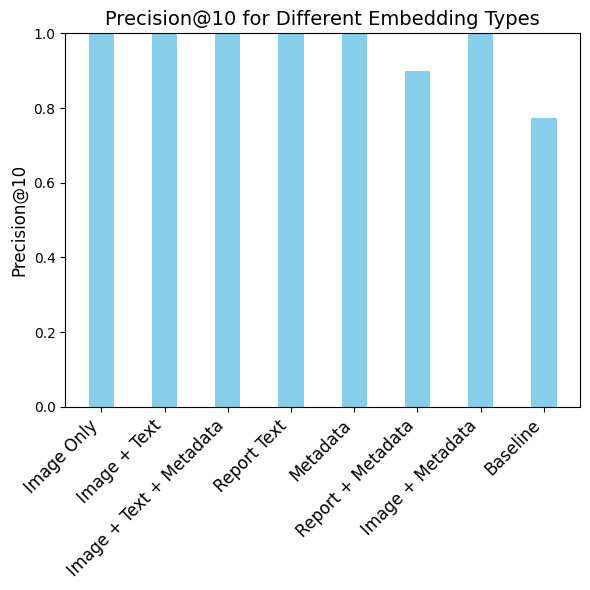

In [20]:
import matplotlib.pyplot as plt


k = 10
precision_values = [
    precision_k_1,
    precision_k_2,
    precision_k_3,
    precision_k_4,
    precision_k_5,
    precision_k_6,
    precision_k_7,
    support_devices_proportion
]

embedding_types = [
    "Image Only",
    "Image + Text",
    "Image + Text + Metadata",
    "Report Text",
    "Metadata",
    "Report + Metadata",
    "Image + Metadata",
    "Baseline"
    
]

plt.figure(figsize=(6, 6))
bars = plt.bar(embedding_types, precision_values, color="skyblue",width=0.4)

# for bar, value in zip(bars, precision_values):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#              f"{value:.4f}", ha='center', va='bottom', fontsize=12)

plt.title(f"Precision@{k} for Different Embedding Types", fontsize=14)
plt.ylabel(f"Precision@{k}", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, 1)  
plt.tight_layout()
plt.show()

In [21]:
analyze_error_slice_tokens(test_results, test_results, k, max_features)

,token,diff_score,error_count,normal_count
659,portable,0.041790,232,12
663,portable chest,0.025031,135,7
937,underwent bedside,0.024334,132,7
57,bedside,0.024334,132,7
605,patient underwent bedside,0.024334,132,7
...,...,...,...,...
607,patient underwent chest,-0.016438,168,125
941,underwent chest radiography,-0.016438,168,125
580,pa,-0.016704,144,105
456,lateral view,-0.017052,162,120


In [22]:
tokens_slice_1 = analyze_error_slice_tokens(slice_1, test_results, k, max_features)
tokens_slice_2 = analyze_error_slice_tokens(slice_2, test_results, k, max_features)
tokens_slice_3 = analyze_error_slice_tokens(slice_3, test_results, k, max_features)
tokens_slice_4 = analyze_error_slice_tokens(slice_4, test_results, k, max_features)
tokens_slice_5 = analyze_error_slice_tokens(slice_5, test_results, k, max_features)
tokens_slice_6 = analyze_error_slice_tokens(slice_6, test_results, k, max_features)
tokens_slice_7 = analyze_error_slice_tokens(slice_7, test_results, k, max_features)

In [23]:
tokens_slice_1.head()

,token,diff_score,error_count,normal_count
670,portable,0.090962,23,12
609,patient underwent bedside,0.076805,18,7
610,patient underwent bedside portable,0.076805,18,7
675,portable chest radiography,0.076805,18,7
674,portable chest,0.076805,18,7


In [24]:
tokens_slice_2.head()

,token,diff_score,error_count,normal_count
672,portable,0.100384,56,12
20,ap,0.069672,41,17
676,portable chest,0.067304,36,7
942,underwent bedside portable chest,0.065189,35,7
60,bedside portable chest radiography,0.065189,35,7


In [25]:
tokens_slice_3.head()

,token,diff_score,error_count,normal_count
684,portable,0.122361,20,12
388,hours examination performed anterior,0.077592,12,7
61,bedside portable chest radiography,0.077592,12,7
940,underwent bedside portable chest,0.077592,12,7
624,performed anterior,0.077592,12,7


In [26]:
tokens_slice_4.head()

,token,diff_score,error_count,normal_count
663,portable,0.092840,16,12
666,portable chest radiography,0.086196,14,7
665,portable chest,0.086196,14,7
610,patient underwent bedside portable,0.086196,14,7
934,underwent bedside,0.086196,14,7


In [27]:
tokens_slice_5.head()

,token,diff_score,error_count,normal_count
660,portable,0.114991,26,12
684,posterior view,0.076538,16,7
686,posterior view patient upright,0.076538,16,7
685,posterior view patient,0.076538,16,7
48,bedside,0.076538,16,7


In [28]:
tokens_slice_6.head()

,token,diff_score,error_count,normal_count
660,portable,0.121117,14,12
311,examination performed anterior,0.081845,9,7
612,patient underwent bedside portable,0.081845,9,7
620,performed anterior,0.081845,9,7
621,performed anterior posterior,0.081845,9,7


In [29]:
tokens_slice_7.head()

,token,diff_score,error_count,normal_count
664,portable,0.108887,44,12
926,tube,0.069784,36,30
621,performed anterior,0.067415,26,7
379,hours examination performed anterior,0.067415,26,7
937,underwent bedside,0.067415,26,7


In [30]:
seed =42
test_df_negative_portable = test_df[(test_df[label_2] == 1) & (test_df[label_1] == 1)].copy()
# rest
test_df_rest = test_df[(test_df[label_2] != 1) | (test_df[label_1] != 1)].copy()
# sample 300 from the rest
test_1 = test_df_negative_portable.sample(n=30, random_state=seed).reset_index(drop=True)
test_2 = test_df_rest.sample(n=270, random_state=seed).reset_index(drop=True)
test = pd.concat([test_1, test_2], ignore_index=True)

In [31]:
test_results_2 = evaluate_best_model(best_model, test, root_folder, label_1)

Evaluating best model...
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for test set...


100%|██████████| 300/300 [00:10<00:00, 28.63it/s]


Original test samples: 300
Valid test samples: 300
Missing test samples: 0


Testing: 100%|██████████| 38/38 [01:42<00:00,  2.70s/it]

Test Accuracy: 0.6300


In [32]:
test_results_1 =test_results_2[test_results_2['true'] == 1].copy()
test_test_results_1_frontal = test_results_1[test_results_1[label_2] == 1].copy()
test_test_results_1_lateral = test_results_1[test_results_1[label_2] != 1].copy()
#  calculate the accuracy for the test results
test_results_1_frontal_acc = accuracy_score(test_test_results_1_frontal["true"], test_test_results_1_frontal["predicted"])
test_results_1_lateral_acc = accuracy_score(test_test_results_1_lateral["true"], test_test_results_1_lateral["predicted"])
print(f"Test results for frontal X-ray (1): {test_results_1_frontal_acc:.4f}")
print(f"Test results for lateral X-ray (0): {test_results_1_lateral_acc:.4f}")

Test results for frontal X-ray (1): 0.1333
Test results for lateral X-ray (0): 0.9032


In [33]:
mk_df = create_meerkat_datapanel(test_results_2, selected_columns)
mk_df = domino_wrapper(mk_df, 'image_embedding', 'true', 'slice_image_only', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_embedding', 'true', 'slice_image_text', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_emebdding_v2', 'true', 'slice_image_text_meta', 'predicted')
mk_df = domino_wrapper(mk_df, "report_embedding", 'true', 'slice_report_text', 'predicted')
mk_df = domino_wrapper(mk_df, "metadata_embedding", 'true', 'slice_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v3", 'true', 'slice_report_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v4", 'true', 'slice_image_metadata', 'predicted')


 14%|█▍        | 14/100 [00:00<00:00, 577.02it/s]


In [39]:
slice_1 = error_slice_producer(4, 'slice_image_only', mk_df, label_2)
precision_k_1 = compute_precision_k(slice_1, label_2, k, attribute)
print(f"Precision@{k} for Image Only Slice: {precision_k_1:.4f}")
slice_1.head(10)

Precision@10 for Image Only Slice: 1.0000


,true,predicted,report_text,metadata_description,Position,slice_score
9,1,0,FINAL REPORT\n EXAMINATION: Chest radiograph....,Patient underwent bedside portable chest radio...,1,1.0
117,0,0,WET READ: ___ ___ ___ 7:53 AM\n \n \n \n T...,Patient underwent bedside portable chest radio...,1,1.0
7,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
23,1,0,FINAL REPORT\n PATIENT HISTORY: ___-year-old ...,Patient underwent bedside portable chest radio...,1,1.0
16,1,0,"FINAL REPORT\n STUDY: AP chest, ___.\n \n CLI...",Patient underwent bedside portable chest radio...,1,1.0
22,1,0,FINAL REPORT\n INDICATION: Left thoracostomy ...,Patient underwent bedside portable chest radio...,1,1.0
11,1,0,FINAL REPORT\n INDICATION: ___-year-old woman...,Patient underwent bedside portable chest radio...,1,1.0
24,1,0,FINAL REPORT\n SINGLE FRONTAL VIEW OF THE CHES...,Patient underwent bedside portable chest radio...,1,1.0
246,0,0,WET READ: ___ ___ ___ 5:54 PM\n Left IJ centr...,Patient underwent bedside portable chest radio...,1,1.0
25,1,0,"FINAL REPORT\n HISTORY: Dyspnea, question pne...",Patient underwent bedside portable chest radio...,1,1.0


In [43]:
slice_2 = error_slice_producer(3, 'slice_image_text', mk_df, label_2)
precision_k_2 = compute_precision_k(slice_2, label_2, k, attribute)
print(f"Precision@{k} for Image + Text Slice: {precision_k_2:.4f}")
slice_2.head(10)

Precision@10 for Image + Text Slice: 1.0000


,true,predicted,report_text,metadata_description,Position,slice_score
220,0,0,CLINICAL INFORMATION & QUESTIONS TO BE ANSWERE...,Patient underwent bedside portable chest radio...,1,1.0
29,1,0,"FINAL REPORT\n AP CHEST, 11:07 A.M., ___\n \n ...",Patient underwent bedside portable chest radio...,1,1.0
15,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
121,0,0,FINAL REPORT\n PORTABLE AP CHEST\n \n CLINICAL...,Patient underwent bedside portable chest radio...,1,1.0
18,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
28,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
10,1,0,FINAL REPORT\n CHEST RADIOGRAPH:\n \n INDICATI...,Patient underwent bedside portable chest radio...,1,1.0
25,1,0,"FINAL REPORT\n HISTORY: Dyspnea, question pne...",Patient underwent bedside portable chest radio...,1,1.0
3,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
9,1,0,FINAL REPORT\n EXAMINATION: Chest radiograph....,Patient underwent bedside portable chest radio...,1,1.0


In [44]:
slice_3 = error_slice_producer(0, 'slice_image_text_meta', mk_df, label_2)
precision_k_3 = compute_precision_k(slice_3, label_2, k, attribute)
print(f"Precision@{k} for Image + Text + Metadata Slice: {precision_k_3:.4f}")
slice_3.head(10)    

Precision@10 for Image + Text + Metadata Slice: 1.0000


,true,predicted,report_text,metadata_description,Position,slice_score
1,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
3,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
28,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
26,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
25,1,0,"FINAL REPORT\n HISTORY: Dyspnea, question pne...",Patient underwent bedside portable chest radio...,1,1.0
24,1,0,FINAL REPORT\n SINGLE FRONTAL VIEW OF THE CHES...,Patient underwent bedside portable chest radio...,1,1.0
23,1,0,FINAL REPORT\n PATIENT HISTORY: ___-year-old ...,Patient underwent bedside portable chest radio...,1,1.0
22,1,0,FINAL REPORT\n INDICATION: Left thoracostomy ...,Patient underwent bedside portable chest radio...,1,1.0
21,1,0,FINAL REPORT\n SINGLE FRONTAL VIEW OF THE CHES...,Patient underwent bedside portable chest radio...,1,1.0
20,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0


In [46]:
slice_4 = error_slice_producer(1, 'slice_report_text', mk_df, label_2)
precision_k_4 = compute_precision_k(slice_4, label_2, k, attribute)
print(f"Precision@{k} for Report Text Slice: {precision_k_4:.4f}")
slice_4.head(10)

Precision@10 for Report Text Slice: 1.0000


,true,predicted,report_text,metadata_description,Position,slice_score
29,1,0,"FINAL REPORT\n AP CHEST, 11:07 A.M., ___\n \n ...",Patient underwent bedside portable chest radio...,1,1.0
14,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
28,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
20,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
26,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
1,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
15,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
3,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
18,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
6,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0


In [52]:
slice_5 = error_slice_producer(0, 'slice_metadata', mk_df, label_2)
precision_k_5 = 0
print(f"Precision@{k} for Metadata Slice: {precision_k_5:.4f}")
slice_5.head(20)

Precision@10 for Metadata Slice: 0.0000


,true,predicted,report_text,metadata_description,Position,slice_score
183,0,1,FINAL REPORT\n HISTORY: New pacemaker implant...,Patient underwent chest radiography in March 2...,1,1.0
242,0,1,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in March 2...,1,1.0


In [57]:
slice_6 = error_slice_producer(4, 'slice_report_metadata', mk_df, label_2)
precision_k_6 = compute_precision_k(slice_6, label_2, k, attribute)
print(f"Precision@{k} for Report + Metadata Slice: {precision_k_6:.4f}")
slice_6["true"].value_counts()

Precision@10 for Report + Metadata Slice: 0.0000


true
1    10
0     3
Name: count, dtype: int64

In [61]:
slice_7= error_slice_producer(3, 'slice_image_metadata', mk_df, label_2)
precision_k_7 = compute_precision_k(slice_7, label_2, k, attribute)
print(f"Precision@{k} for Image + Metadata Slice: {precision_k_7:.4f}")
slice_7.head(10)


Precision@10 for Image + Metadata Slice: 1.0000


,true,predicted,report_text,metadata_description,Position,slice_score
0,1,1,WET READ: ___ ___ ___ 10:19 PM\n Relative luc...,Patient underwent bedside portable chest radio...,1,1.0
3,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
5,1,0,WET READ: ___ ___ ___ 9:02 AM\n ET tube is ap...,Patient underwent bedside portable chest radio...,1,1.0
9,1,0,FINAL REPORT\n EXAMINATION: Chest radiograph....,Patient underwent bedside portable chest radio...,1,1.0
14,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
16,1,0,"FINAL REPORT\n STUDY: AP chest, ___.\n \n CLI...",Patient underwent bedside portable chest radio...,1,1.0
23,1,0,FINAL REPORT\n PATIENT HISTORY: ___-year-old ...,Patient underwent bedside portable chest radio...,1,1.0
24,1,0,FINAL REPORT\n SINGLE FRONTAL VIEW OF THE CHES...,Patient underwent bedside portable chest radio...,1,1.0
25,1,0,"FINAL REPORT\n HISTORY: Dyspnea, question pne...",Patient underwent bedside portable chest radio...,1,1.0
29,1,0,"FINAL REPORT\n AP CHEST, 11:07 A.M., ___\n \n ...",Patient underwent bedside portable chest radio...,1,1.0


In [62]:
# the samples with wrong predictions
test_results_incorrect = test_results_2[test_results_2['true'] != test_results['predicted']].copy()
# calculate the suppoting devices proportion
test_results_incorrect[label_2] = test_results_incorrect[label_2].fillna(0)
support_devices_count = test_results_incorrect[label_2].sum()
total_count = len(test_results_incorrect)
support_devices_proportion = support_devices_count / total_count if total_count > 0 else 0
print(f"Support Devices Proportion in Incorrect Predictions: {support_devices_proportion:.4f}")

Support Devices Proportion in Incorrect Predictions: 0.4837


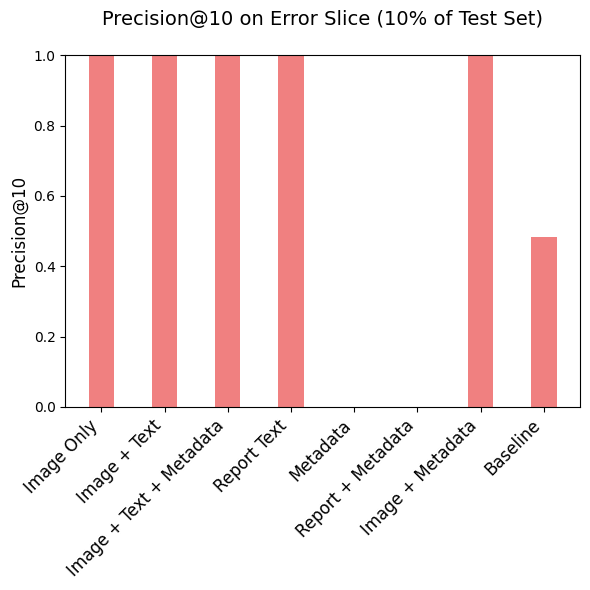

In [63]:
k = 10
precision_values = [
    precision_k_1,
    precision_k_2,
    precision_k_3,
    precision_k_4,
    precision_k_5,
    precision_k_6,
    precision_k_7,
    support_devices_proportion
]

embedding_types = [
    "Image Only",
    "Image + Text",
    "Image + Text + Metadata",
    "Report Text",
    "Metadata",
    "Report + Metadata",
    "Image + Metadata",
    "Baseline"
    
]

plt.figure(figsize=(6, 6))
bars = plt.bar(embedding_types, precision_values, color="lightcoral",width=0.4)

# for bar, value in zip(bars, precision_values):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#              f"{value:.4f}", ha='center', va='bottom', fontsize=12)

plt.title(
    f"Precision@{k} on Error Slice (10% of Test Set)\n",
    fontsize=14
)
plt.ylabel(f"Precision@{k}", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, 1)  
plt.tight_layout()
plt.show()

In [64]:
c = analyze_error_slice_tokens(test_results, test_results, k, max_features)
c.head(10)

,token,diff_score,error_count,normal_count
659,portable,0.041790,232,12
663,portable chest,0.025031,135,7
937,underwent bedside,0.024334,132,7
57,bedside,0.024334,132,7
605,patient underwent bedside,0.024334,132,7
59,bedside portable chest,0.023917,129,7
58,bedside portable,0.023917,129,7
664,portable chest radiography,0.023917,129,7
60,bedside portable chest radiography,0.023917,129,7
606,patient underwent bedside portable,0.023917,129,7


In [65]:
seed =42
test_df_negative_portable = test_df[(test_df[label_2] == 1) & (test_df[label_1] == 1)].copy()
# rest
test_df_rest = test_df[(test_df[label_2] != 1) | (test_df[label_1] != 1)].copy()
# sample 300 from the rest
test_1 = test_df_negative_portable.sample(n=15, random_state=seed).reset_index(drop=True)
test_2 = test_df_rest.sample(n=285, random_state=seed).reset_index(drop=True)
test = pd.concat([test_1, test_2], ignore_index=True)

In [66]:
test_results_3 = evaluate_best_model(best_model, test, root_folder, label_1)

Evaluating best model...
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for test set...


100%|██████████| 300/300 [00:05<00:00, 57.05it/s] 


Original test samples: 300
Valid test samples: 300
Missing test samples: 0


Testing: 100%|██████████| 38/38 [00:18<00:00,  2.03it/s]

Test Accuracy: 0.6633


In [67]:
test_results_3.groupby(['Position', 'Finding']).size().unstack(fill_value=0)

Finding,0,1
Position,,
0,30,134
1,121,15


In [68]:
mk_df = create_meerkat_datapanel(test_results_3, selected_columns)
mk_df = domino_wrapper(mk_df, 'image_embedding', 'true', 'slice_image_only', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_embedding', 'true', 'slice_image_text', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_emebdding_v2', 'true', 'slice_image_text_meta', 'predicted')
mk_df = domino_wrapper(mk_df, "report_embedding", 'true', 'slice_report_text', 'predicted')
mk_df = domino_wrapper(mk_df, "metadata_embedding", 'true', 'slice_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v3", 'true', 'slice_report_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v4", 'true', 'slice_image_metadata', 'predicted')

 10%|█         | 10/100 [00:00<00:00, 287.14it/s]


In [73]:
slice_1= error_slice_producer(4, 'slice_image_only', mk_df, label_2)
precision_k_1 = compute_precision_k(slice_1, label_2, k, attribute)
print(f"Precision@{k} for Image Only Slice: {precision_k_1:.4f}")
slice_1.head(10)
slice_1['true'].value_counts()



Precision@10 for Image Only Slice: 0.0000


true
0    15
1    14
Name: count, dtype: int64

In [79]:
slice_2 =error_slice_producer(3, 'slice_image_text', mk_df, label_2)
precision_k_2 = compute_precision_k(slice_2, label_2, k, attribute)
print(f"Precision@{k} for Image + Text Slice: {precision_k_2:.4f}")
slice_2.head(10)

Precision@10 for Image + Text Slice: 0.0000


,true,predicted,report_text,metadata_description,Position,slice_score
79,1,0,FINAL REPORT\n PA AND LATERAL VIEWS OF THE CHE...,Patient underwent chest radiography in May 214...,0,1.0
133,1,1,FINAL REPORT\n EXAM: Chest frontal and latera...,Patient underwent chest radiography in May 213...,0,1.0


In [84]:
slice_3 = error_slice_producer(1, 'slice_image_text_meta', mk_df, label_2)
precision_k_3 = 0
print(f"Precision@{k} for Image + Text + Metadata Slice: {precision_k_3:.4f}")
slice_3.head(10)

Precision@10 for Image + Text + Metadata Slice: 0.0000


,true,predicted,report_text,metadata_description,Position,slice_score
85,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
151,0,1,FINAL REPORT\n REASON FOR EXAMINATION: Fever ...,Patient underwent bedside portable chest radio...,1,1.0
163,0,1,FINAL REPORT\n SINGLE FRONTAL VIEW OF THE CHES...,Patient underwent bedside portable chest radio...,1,1.0
201,0,1,FINAL REPORT\n STUDY: AP chest ___.\n \n CLIN...,Patient underwent bedside portable chest radio...,1,1.0
281,0,1,WET READ: ___ ___ ___ 6:48 PM\n No acute card...,Patient underwent bedside portable chest radio...,1,1.0
244,0,1,FINAL REPORT\n INDICATION: Partial nephrectom...,Patient underwent bedside portable chest radio...,1,1.0
248,0,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
107,0,1,"FINAL REPORT\n AP CHEST, 11:07 P.M., ___\n \n ...",Patient underwent bedside portable chest radio...,1,1.0
72,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
241,0,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0


In [90]:
slice_4 = error_slice_producer(0, 'slice_report_text', mk_df, label_2)
precision_k_4 = compute_precision_k(slice_4, label_2, k, attribute)
print(f"Precision@{k} for Report Text Slice: {precision_k_4:.4f}")
slice_4.head(10)

Precision@10 for Report Text Slice: 0.1000


,true,predicted,report_text,metadata_description,Position,slice_score
1,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
79,1,0,FINAL REPORT\n PA AND LATERAL VIEWS OF THE CHE...,Patient underwent chest radiography in May 214...,0,1.0
290,1,0,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in Novembe...,0,1.0
272,1,0,FINAL REPORT\n INDICATION: History: ___M with...,Patient underwent chest radiography in August ...,0,1.0
253,1,0,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in March 2...,0,1.0
194,1,0,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in Novembe...,0,1.0
169,1,0,"FINAL REPORT\n PA AND LATERAL CHEST FILM, ___ ...",Patient underwent chest radiography in August ...,0,1.0
141,1,0,FINAL REPORT\n INDICATION: ___ year old man w...,Patient underwent chest radiography in June 21...,0,1.0
116,1,0,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in August ...,0,1.0
66,1,0,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in Septemb...,0,1.0


In [96]:
slice_5 = error_slice_producer(3, 'slice_metadata', mk_df, label_2)
precision_k_5 = compute_precision_k(slice_5, label_2, k, attribute)
print(f"Precision@{k} for Metadata Slice: {precision_k_5:.4f}")
slice_5.head(10)

Precision@10 for Metadata Slice: 0.0000


,true,predicted,report_text,metadata_description,Position,slice_score
283,1,1,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in Novembe...,0,1.0
245,1,1,FINAL REPORT\n HISTORY: VATS with left lower ...,Patient underwent chest radiography in August ...,0,1.0
25,1,1,FINAL REPORT\n REASON FOR EXAM: Patient with ...,Patient underwent chest radiography in Septemb...,0,1.0
30,1,1,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in October...,0,1.0
39,0,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n TECHNIQUE...,Patient underwent chest radiography in August ...,0,1.0
69,1,1,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in August ...,0,1.0
83,1,1,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in May 212...,0,1.0
92,1,1,FINAL REPORT\n HISTORY: Male status post pace...,Patient underwent chest radiography in January...,0,1.0
22,1,1,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in Novembe...,0,1.0
150,1,1,WET READ: ___ ___ 8:43 PM\n No acute intratho...,Patient underwent chest radiography in Novembe...,0,1.0


In [99]:
slice_6 = error_slice_producer(4, 'slice_report_metadata', mk_df, label_2)
precision_k_6 = compute_precision_k(slice_6, label_2, k, attribute)
print(f"Precision@{k} for Report + Metadata Slice: {precision_k_6:.4f}")
slice_6.head(10)

Precision@10 for Report + Metadata Slice: 0.0000


,true,predicted,report_text,metadata_description,Position,slice_score
57,1,1,FINAL REPORT\n REASON FOR EXAMINATION: Persis...,Patient underwent chest radiography in Novembe...,0,1.000000
96,0,1,FINAL REPORT\n REASON FOR EXAMINATION: Recent...,Patient underwent chest radiography in Februar...,0,1.000000
191,0,1,"FINAL REPORT\n REASON FOR EXAMINATION: Cough,...",Patient underwent chest radiography in June 21...,0,1.000000
292,1,1,FINAL REPORT\n REASON FOR EXAMINATION: Evalua...,Patient underwent chest radiography in July 21...,0,1.000000
256,1,1,FINAL REPORT\n REASON FOR EXAMINATION: Evalua...,Patient underwent chest radiography in October...,0,1.000000
176,1,1,FINAL REPORT\n REASON FOR EXAMINATION: Evalua...,Patient underwent chest radiography in Februar...,0,1.000000
296,1,1,FINAL REPORT\n REASON FOR EXAMINATION: Evalua...,Patient underwent chest radiography in August ...,0,1.000000
196,0,1,FINAL REPORT\n REASON FOR EXAMINATION: Abnorm...,Patient underwent chest radiography in March 2...,0,1.000000
181,1,1,FINAL REPORT\n REASON FOR EXAMINATION: Follow...,Patient underwent chest radiography in August ...,0,0.999999


In [103]:
slice_7 = error_slice_producer(3, 'slice_image_metadata', mk_df, label_2)
precision_k_7 = 0
print(f"Precision@{k} for Image + Metadata Slice: {precision_k_7:.4f}")
slice_7.head(20)

Precision@10 for Image + Metadata Slice: 0.0000


,true,predicted,report_text,metadata_description,Position,slice_score
15,1,0,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in April 2...,0,1.000000
66,1,0,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in Septemb...,0,1.000000
79,1,0,FINAL REPORT\n PA AND LATERAL VIEWS OF THE CHE...,Patient underwent chest radiography in May 214...,0,1.000000
141,1,0,FINAL REPORT\n INDICATION: ___ year old man w...,Patient underwent chest radiography in June 21...,0,1.000000
233,1,1,FINAL REPORT\n PA AND LATERAL CHEST FILM ___ A...,Patient underwent chest radiography in July 21...,0,1.000000
272,1,0,FINAL REPORT\n INDICATION: History: ___M with...,Patient underwent chest radiography in August ...,0,1.000000
298,1,0,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in August ...,0,1.000000
288,1,1,FINAL REPORT\n CHEST RADIOGRAPH PERFORMED ON _...,Patient underwent chest radiography in Septemb...,0,1.000000
174,1,1,FINAL REPORT\n HISTORY: Pleural effusion eval...,Patient underwent chest radiography in August ...,0,1.000000
63,1,1,FINAL REPORT\n PA AND LATERAL CHEST ___\n \n C...,Patient underwent chest radiography in July 21...,0,1.000000


In [105]:
# the samples with wrong predictions
test_results_incorrect = test_results_3[test_results_3['true'] != test_results['predicted']].copy()
# calculate the suppoting devices proportion
test_results_incorrect[label_2] = test_results_incorrect[label_2].fillna(0)
support_devices_count = test_results_incorrect[label_2].sum()
total_count = len(test_results_incorrect)
support_devices_proportion = support_devices_count / total_count if total_count > 0 else 0
print(f"Support Devices Proportion in Incorrect Predictions: {support_devices_proportion:.4f}")

Support Devices Proportion in Incorrect Predictions: 0.4610


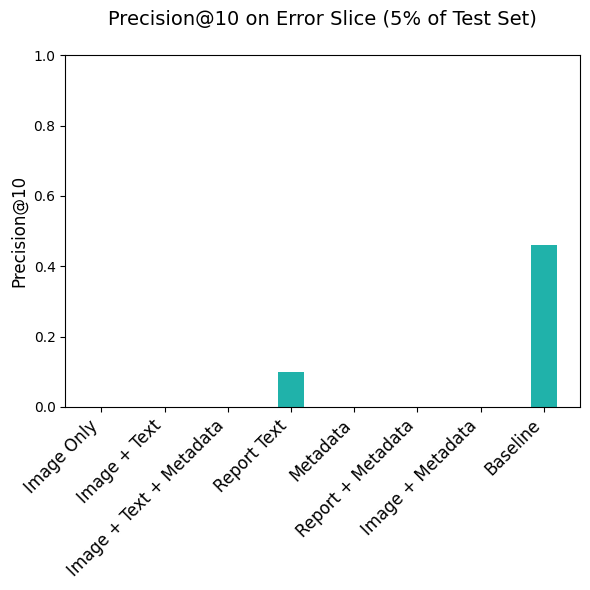

In [106]:



k = 10
precision_values = [
    precision_k_1,
    precision_k_2,
    precision_k_3,
    precision_k_4,
    precision_k_5,
    precision_k_6,
    precision_k_7,
    support_devices_proportion
]

embedding_types = [
    "Image Only",
    "Image + Text",
    "Image + Text + Metadata",
    "Report Text",
    "Metadata",
    "Report + Metadata",
    "Image + Metadata",
    "Baseline"
    
]

plt.figure(figsize=(6, 6))
bars = plt.bar(embedding_types, precision_values, color="lightseagreen",width=0.4)

# for bar, value in zip(bars, precision_values):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#              f"{value:.4f}", ha='center', va='bottom', fontsize=12)

plt.title(
    f"Precision@{k} on Error Slice (5% of Test Set)\n",
    fontsize=14
)
plt.ylabel(f"Precision@{k}", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, 1)  
plt.tight_layout()
plt.show()

Deepseek